### Read data

In [2]:
import mne
import numpy as np
import pandas as pd
import pickle
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
GEST = 5          # количество основных жестов (кроме 'битых' данных)
PL = 3            # количество пилотов (независимых рядов данных)
SENS = 50         # количество датчиков

gestures = ['"open"',  # 0
            '"пистолет"',  # 1
            'сгиб большого пальца',  # 2
            '"ok"',  # 3
            '"grab"',  # 4
            '"битые" данные',  # -1
            ]

In [4]:
mounts = {
    1 : {
        'path_X_train' : 'data/X_train_1.npy',
        'path_y_train' : 'data/y_train_1.npy',
        'path_X_test_dataset' : 'data/X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'data/X_train_2.npy',
        'path_y_train' : 'data/y_train_2.npy',
        'path_X_test_dataset' : 'data/X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'data/X_train_3.npy',
        'path_y_train' : 'data/y_train_3.npy',
        'path_X_test_dataset' : 'data/X_test_dataset_3.pkl',
    }
}

In [5]:
for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(mount['path_X_train'])
    mount['y_train'] = np.load(mount['path_y_train'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/X_train_1.npy'

### Cut "plain" locations

In [5]:
SFREQ = 1000.0 / 33


for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(50).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.


In [6]:
# вырезаем участки без перехода в 'X_train_plain','y_train_plain'
t_int, t_clear = 77, 46   # фактически вместо t_clear = 46 устанавливаем tmin=-1 * 1.5

for mount_name, mount in mounts.items():
    raw = mount['raw']
    y_train = mount['y_train']
    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]
    
    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1 * 1.5,
        tmax=1 * 0,
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn_ = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn_ = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    print(X_train_nn_.shape, y_train_nn_.shape)
    
    i_broken = np.unique(np.where(y_train_nn_ == -1)[0])
    print('битые данные ', i_broken)
    X_train_nn = np.delete(X_train_nn_, i_broken, axis = 0)
    y_train_nn = np.delete(y_train_nn_, i_broken, axis = 0)
    # y_train_nn = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_plain'] = X_train_nn
    mount['y_train_plain'] = y_train_nn.astype(np.int8)

    print(X_train_nn.shape, y_train_nn.shape)

Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 46 original time points ...
0 bad epochs dropped
(277, 46, 50) (277, 46, 1)
битые данные  []
(277, 46, 50) (277, 46, 1)
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 46 original time points ...
0 bad epochs dropped
(264, 46, 50) (264, 46, 1)
битые данные  [145 147 232 239]
(260, 46, 50) (260, 46, 1)
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 268 events and 46 original time points ...
0 bad epochs dropped
(268, 46, 50) (268, 46, 1)
битые данные  []
(268, 46, 50) (268, 46, 1)


In [7]:
for mount_name, mount in mounts.items():      # для каждого паттерна должен быть 1 жест
    for s in mount['y_train_plain']:            
        print(s[0], '  ', s[43], '  ', s[0] == s[43] if True else '')

[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]    [ True]
[0]    [0]    [ True]
[4]    [4]    [ True]
[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]    [ True]
[0]    [0]    [ True]
[4]    [4]    [ True]
[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]    [ True]
[0]    [0]    [ True]
[4]    [4]    [ True]
[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]    [ True]
[0]    [0]    [ True]
[4]    [4]    [ True]
[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]    [ True]
[0]    [0]    [ True]
[4]    [4]    [ True]
[0]    [0]    [ True]
[2]    [2]    [ True]
[0]    [0]    [ True]
[1]    [1]    [ True]
[0]    [0]    [ True]
[3]    [3]

In [8]:
mounts[3]['X_train_plain'][260]         # смотрим на формат данных

array([[2248.,    8., 1515., ...,    5.,   20.,    9.],
       [2245.,   10., 1515., ...,    5.,   30.,    9.],
       [2245.,    8., 1520., ...,    6.,   23.,    9.],
       ...,
       [2280.,    5., 1510., ...,    6.,   32.,    8.],
       [2276.,    8., 1515., ...,    5.,   24.,    9.],
       [2274.,    7., 1512., ...,    6.,   30.,    8.]])

In [9]:
# Объединяем нарезку по X и по y в потоки данных и переводим в формат DataFrame
for mount_name, mount in mounts.items():
    X_train_plain = mount['X_train_plain']
    y_train_plain = mount['y_train_plain']
    
    X_train_plain_df = pd.DataFrame(columns=[f'sen_{s}' for s in range(SENS)])
    y_train_plain_df = pd.DataFrame(columns=['Class'])
    for samp in range(X_train_plain.shape[0]):
        xx = pd.DataFrame(data=X_train_plain[samp], columns=[f'sen_{s}' for s in range(SENS)])
        X_train_plain_df = pd.concat([X_train_plain_df, xx], ignore_index=True)
        yy = pd.DataFrame(data=y_train_plain[samp], columns=['Class'])
        y_train_plain_df = pd.concat([y_train_plain_df, yy], ignore_index=True)
    mount['X_train_plain_df'] = X_train_plain_df
    y_train_plain_df = y_train_plain_df['Class'].apply(int)
    mount['y_train_plain_df'] = y_train_plain_df

In [10]:
y_train_plain_df

0        0
1        0
2        0
3        0
4        0
        ..
12323    1
12324    1
12325    1
12326    1
12327    1
Name: Class, Length: 12328, dtype: int64

In [11]:
mounts[2]['X_train_plain_df']

,sen_0,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,sen_7,sen_8,sen_9,...,sen_40,sen_41,sen_42,sen_43,sen_44,sen_45,sen_46,sen_47,sen_48,sen_49
0,1181.0,13.0,1540.0,160.0,10.0,2523.0,75.0,72.0,2665.0,55.0,...,8.0,18.0,6.0,29.0,9.0,12.0,44.0,4.0,11.0,18.0
1,1174.0,18.0,1540.0,156.0,8.0,2525.0,75.0,72.0,2668.0,55.0,...,9.0,11.0,5.0,27.0,7.0,12.0,46.0,7.0,7.0,8.0
2,1181.0,17.0,1542.0,154.0,8.0,2522.0,74.0,74.0,2670.0,66.0,...,8.0,10.0,6.0,28.0,8.0,10.0,46.0,11.0,12.0,10.0
3,1182.0,14.0,1541.0,156.0,7.0,2522.0,76.0,73.0,2670.0,56.0,...,8.0,12.0,8.0,28.0,8.0,10.0,46.0,8.0,11.0,10.0
4,1182.0,14.0,1539.0,157.0,7.0,2524.0,76.0,72.0,2668.0,55.0,...,11.0,10.0,6.0,29.0,9.0,12.0,48.0,4.0,12.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11955,786.0,26.0,1576.0,105.0,9.0,1661.0,91.0,106.0,2459.0,45.0,...,10.0,15.0,8.0,24.0,8.0,10.0,51.0,7.0,12.0,10.0
11956,787.0,28.0,1573.0,104.0,7.0,1654.0,88.0,109.0,2444.0,57.0,...,8.0,8.0,8.0,23.0,11.0,10.0,50.0,10.0,10.0,10.0
11957,791.0,24.0,1577.0,101.0,9.0,1656.0,89.0,106.0,2433.0,47.0,...,10.0,14.0,6.0,20.0,8.0,11.0,50.0,9.0,9.0,10.0
11958,793.0,25.0,1578.0,98.0,8.0,1660.0,93.0,106.0,2426.0,50.0,...,11.0,10.0,7.0,26.0,8.0,10.0,48.0,7.0,11.0,9.0


In [12]:
# Объединяем потоки X и y в формате DataFrame и добавляем колонку 
# с характеристикой начало-середина-конец данных
for mount_name, mount in mounts.items():
    X_train_plain_df = mount['X_train_plain_df']
    y_train_plain_df = mount['y_train_plain_df']
    Xy_train_plain_df = pd.concat([X_train_plain_df, y_train_plain_df], axis=1)
    Xy_train_plain_df['Class_name'] = Xy_train_plain_df['Class'].apply(lambda x: gestures[x])
    t_th = X_train_plain_df.shape[0] // 3
    Xy_train_plain_df['b_e'] = Xy_train_plain_df.apply(lambda row: 'b' if row.name <= t_th 
                                                       else ('e' if row.name >= t_th * 2
                                                       else 'p'), axis=1)
    mount['Xy_train_plain_df'] = Xy_train_plain_df
    display(Xy_train_plain_df.head())

,sen_0,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,sen_7,sen_8,sen_9,...,sen_43,sen_44,sen_45,sen_46,sen_47,sen_48,sen_49,Class,Class_name,b_e
0,2604.0,15.0,1720.0,118.0,6.0,2461.0,84.0,54.0,2439.0,49.0,...,21.0,5.0,14.0,33.0,9.0,11.0,5.0,0,"""open""",b
1,2604.0,14.0,1721.0,114.0,9.0,2461.0,83.0,48.0,2438.0,49.0,...,29.0,10.0,12.0,34.0,6.0,10.0,7.0,0,"""open""",b
2,2604.0,18.0,1721.0,117.0,10.0,2462.0,85.0,50.0,2438.0,50.0,...,22.0,8.0,10.0,34.0,8.0,13.0,7.0,0,"""open""",b
3,2602.0,18.0,1721.0,118.0,10.0,2461.0,85.0,57.0,2436.0,48.0,...,20.0,4.0,10.0,33.0,3.0,12.0,6.0,0,"""open""",b
4,2600.0,18.0,1719.0,113.0,6.0,2461.0,82.0,55.0,2434.0,48.0,...,24.0,6.0,11.0,35.0,7.0,13.0,6.0,0,"""open""",b


,sen_0,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,sen_7,sen_8,sen_9,...,sen_43,sen_44,sen_45,sen_46,sen_47,sen_48,sen_49,Class,Class_name,b_e
0,1181.0,13.0,1540.0,160.0,10.0,2523.0,75.0,72.0,2665.0,55.0,...,29.0,9.0,12.0,44.0,4.0,11.0,18.0,0,"""open""",b
1,1174.0,18.0,1540.0,156.0,8.0,2525.0,75.0,72.0,2668.0,55.0,...,27.0,7.0,12.0,46.0,7.0,7.0,8.0,0,"""open""",b
2,1181.0,17.0,1542.0,154.0,8.0,2522.0,74.0,74.0,2670.0,66.0,...,28.0,8.0,10.0,46.0,11.0,12.0,10.0,0,"""open""",b
3,1182.0,14.0,1541.0,156.0,7.0,2522.0,76.0,73.0,2670.0,56.0,...,28.0,8.0,10.0,46.0,8.0,11.0,10.0,0,"""open""",b
4,1182.0,14.0,1539.0,157.0,7.0,2524.0,76.0,72.0,2668.0,55.0,...,29.0,9.0,12.0,48.0,4.0,12.0,8.0,0,"""open""",b


,sen_0,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,sen_7,sen_8,sen_9,...,sen_43,sen_44,sen_45,sen_46,sen_47,sen_48,sen_49,Class,Class_name,b_e
0,1091.0,0.0,1245.0,41.0,5.0,1615.0,20.0,10.0,1481.0,12.0,...,42.0,9.0,10.0,31.0,6.0,28.0,9.0,0,"""open""",b
1,1097.0,10.0,1252.0,44.0,10.0,1622.0,19.0,10.0,1500.0,11.0,...,42.0,9.0,7.0,32.0,8.0,25.0,9.0,0,"""open""",b
2,1109.0,9.0,1261.0,49.0,8.0,1643.0,19.0,9.0,1534.0,11.0,...,41.0,7.0,9.0,30.0,6.0,25.0,8.0,0,"""open""",b
3,1121.0,12.0,1264.0,51.0,10.0,1670.0,20.0,10.0,1570.0,12.0,...,48.0,8.0,9.0,32.0,6.0,25.0,10.0,0,"""open""",b
4,1131.0,11.0,1275.0,54.0,8.0,1695.0,18.0,9.0,1602.0,13.0,...,47.0,9.0,6.0,30.0,6.0,28.0,9.0,0,"""open""",b


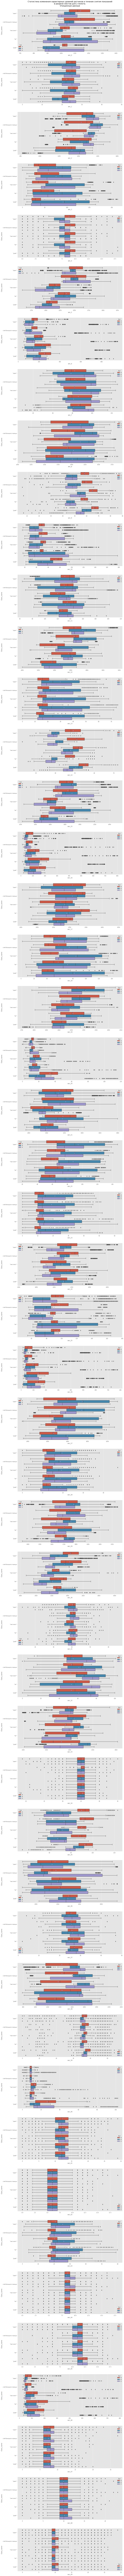

In [21]:
mount_name = 2
Xy_train_plain_df = mounts[mount_name]['Xy_train_plain_df']

plt.style.use('ggplot')
fig, axes = plt.subplots(SENS, 1, figsize=(16, 400))

for sens in range(SENS):
    boxplot = sns.boxplot(data=Xy_train_plain_df, x=f'sen_{sens}', y='Class_name', 
                            ax=axes[sens], hue='b_e', orient='h', 
                            width=0.9, dodge=True, showmeans=True)

axes[0].set_title(f'Статистика изменения характерных уровней датчиков в течение снятия показаний\n'
               + f'в разрезе жестов для {mount_name} пилота.\n'
               + f'Очищенные данные\n', 
               fontsize=16);
# plt.show()